In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import gc
import datetime
import os
from tensorboard.plugins import projector
from sklearn.manifold import TSNE
import sklearn as skl
print(tf.config.experimental.list_physical_devices()) # CPU + GPU

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU')]


In [2]:
def embedding_size_from_field_size(field_size, dataset_size, emb_base=1):
    return int(emb_base * (field_size + 16 + dataset_size / dataset_size) ** 0.8)

def draw_function(save_location=None):
    global model
    global dataset
    global validation_start
    global test_start
    global y_pred
    fig = plt.figure(figsize=(24, 18))
    gs = fig.add_gridspec(3, 4)
    ax1 = fig.add_subplot(gs[:, :3])
    plt.title("geo-loc embedding space")
    X_embedded = TSNE(n_components=2).fit_transform(model.get_layer(name="embedding_geo_loc").weights[0].numpy())
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c='k', marker='o', alpha=0.5, edgecolors='none')
    fpr, tpr, thresholds = skl.metrics.roc_curve(dataset[validation_start:test_start, 0], y_pred[validation_start:test_start])
    half_idx = np.argmax(thresholds < 0.5)
    ax2 = fig.add_subplot(gs[0, 3])
    ax2.plot(fpr, tpr, c='b')
    ax2.vlines(x=fpr[half_idx], ymin=0, ymax=1, colors='r')
    ax2.hlines(y=tpr[half_idx], xmin=0, xmax=1, colors='r')
    ax2.scatter(fpr[half_idx], tpr[half_idx], marker='x', c='g')
    ax2.plot([0, 1], [0, 1], '.-.')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    auc = skl.metrics.roc_auc_score(dataset[validation_start:test_start, 0], y_pred[validation_start:test_start])
    plt.title("ROC curve" + " (AUC = " + str(int(auc * 10000) / 100) + "%)")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    prec, reca, thresh = skl.metrics.precision_recall_curve(dataset[validation_start:test_start, 0], y_pred[validation_start:test_start])
    half_idx = np.argmax(thresh < 0.5)
    ax3 = fig.add_subplot(gs[1, 3])
    ax3.plot(reca, prec, c='b')
    ax3.scatter(reca[half_idx], prec[half_idx], marker='x', c='g')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision - Recall curve")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    ax4 = fig.add_subplot(gs[2, 3])
    conf = np.array(skl.metrics.confusion_matrix(y_true=dataset[validation_start:test_start, 0], y_pred=(y_pred[validation_start:test_start] > 0.5)))
    ax4.imshow(([conf[:, 1], conf[:, 0]]), cmap='OrRd')
    ax4.text(0, 0, str(conf[0, 1]) + "\n(" + str(int(conf[0, 1] / np.sum(conf) * 10000) / 100) + "%)", horizontalalignment="center", verticalalignment="center")
    ax4.text(1, 0, str(conf[1, 1]) + "\n(" + str(int(conf[1, 1] / np.sum(conf) * 10000) / 100) + "%)", horizontalalignment="center", verticalalignment="center")
    ax4.text(0, 1, str(conf[0, 0]) + "\n(" + str(int(conf[0, 0] / np.sum(conf) * 10000) / 100) + "%)", horizontalalignment="center", verticalalignment="center")
    ax4.text(1, 1, str(conf[1, 0]) + "\n(" + str(int(conf[1, 0] / np.sum(conf) * 10000) / 100) + "%)", horizontalalignment="center", verticalalignment="center")
    plt.title("Confusion matrix")
    plt.xlabel("label")
    plt.ylabel("predicted")
    plt.xticks([0, 1], ["Not clicked", "Clicked"], rotation=0)
    plt.yticks([0, 1], ["Clicked", "Not clicked"], rotation=90)
    if not save_location == None:
        fig.savefig(save_location)
    plt.show()

In [8]:
dataset = np.load("....dataset.npy", mmap_mode='r')
label_col = 8
validation_start = int(dataset.shape[0] * 0.8)
test_start = int(dataset.shape[0] * 0.9)
ones_percentage = np.sum(dataset[:, label_col]) / dataset.shape[0]
zeros_percentage = 1 - np.sum(dataset[:, label_col]) / dataset.shape[0]
fields = ["campaign_id", "advertiser_id", "platform", "geo_loc", "cur_doc_source_id", "cur_doc_publisher_id", "target_doc_source_id", "target_doc_publisher_id", "click", "tar_doc_topic_id", "cur_doc_cat_id", "tar_doc_cat_id"]
field_sizes = [32676, 4174, 3, 2919, 4807, 485, 6991, 883, 301, 301, 91, 96]
num_fields = len(fields)

34800/34800 - 932s - accuracy: 0.6588 - val_loss: 0.6061 - val_auc_1: 0.3950 - val_accuracy: 0.6652 - auc: 0.7308 - val_auc: 0.7254 - auc_1: 0.4013 - loss: 0.2034
34800/34800 - 879s - accuracy: 0.6631 - val_loss: 0.6066 - val_auc_1: 0.3972 - val_accuracy: 0.6607 - auc: 0.7343 - val_auc: 0.7268 - auc_1: 0.4063 - loss: 0.1903
34800/34800 - 887s - accuracy: 0.6638 - val_loss: 0.6014 - val_auc_1: 0.3985 - val_accuracy: 0.6716 - auc: 0.7347 - val_auc: 0.7275 - auc_1: 0.4071 - loss: 0.1902
34800/34800 - 887s - accuracy: 0.6643 - val_loss: 0.6092 - val_auc_1: 0.3975 - val_accuracy: 0.6609 - auc: 0.7348 - val_auc: 0.7273 - auc_1: 0.4074 - loss: 0.1903
34800/34800 - 887s - accuracy: 0.6645 - val_loss: 0.6110 - val_auc_1: 0.3991 - val_accuracy: 0.6592 - auc: 0.7349 - val_auc: 0.7277 - auc_1: 0.4076 - loss: 0.1902
34800/34800 - 886s - accuracy: 0.6642 - val_loss: 0.6028 - val_auc_1: 0.3999 - val_accuracy: 0.6668 - auc: 0.7350 - val_auc: 0.7287 - auc_1: 0.4077 - loss: 0.1902
34800/34800 - 886s - a

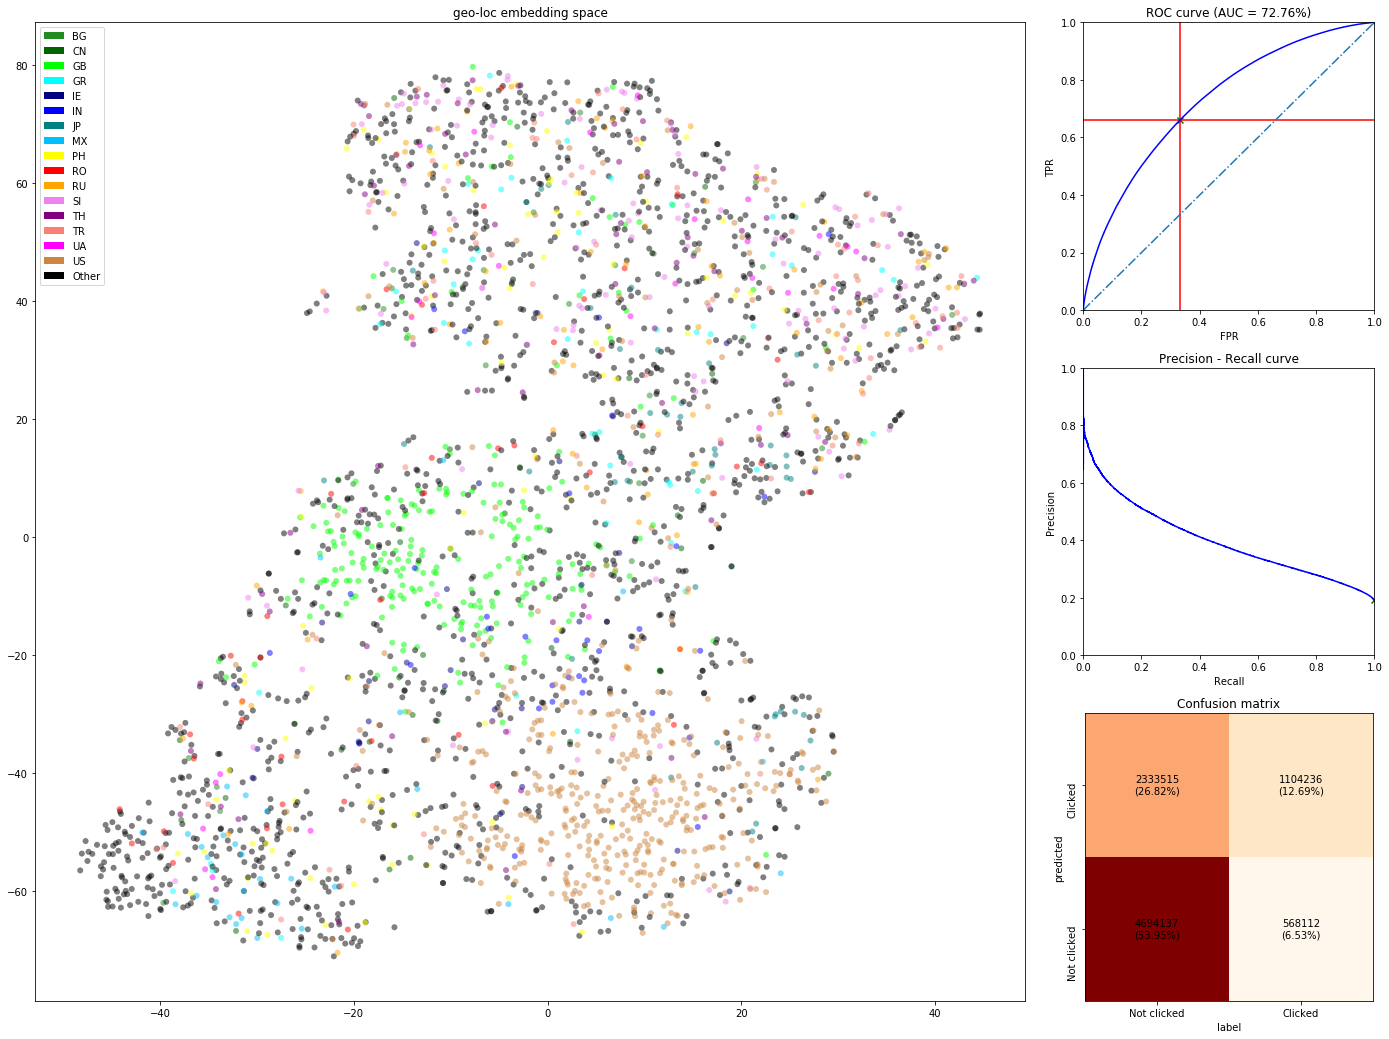

34800/34800 - 907s - accuracy: 0.6590 - val_loss: 0.6011 - val_auc_1: 0.3983 - val_accuracy: 0.6630 - auc: 0.7323 - val_auc: 0.7269 - auc_1: 0.4034 - loss: 0.2029
34800/34800 - 867s - accuracy: 0.6613 - val_loss: 0.6042 - val_auc_1: 0.3996 - val_accuracy: 0.6590 - auc: 0.7350 - val_auc: 0.7286 - auc_1: 0.4079 - loss: 0.1902
34800/34800 - 866s - accuracy: 0.6612 - val_loss: 0.6059 - val_auc_1: 0.3999 - val_accuracy: 0.6573 - auc: 0.7353 - val_auc: 0.7281 - auc_1: 0.4084 - loss: 0.1901
34800/34800 - 866s - accuracy: 0.6610 - val_loss: 0.6058 - val_auc_1: 0.3996 - val_accuracy: 0.6604 - auc: 0.7354 - val_auc: 0.7288 - auc_1: 0.4086 - loss: 0.1901
34800/34800 - 865s - accuracy: 0.6611 - val_loss: 0.5999 - val_auc_1: 0.4005 - val_accuracy: 0.6671 - auc: 0.7354 - val_auc: 0.7284 - auc_1: 0.4088 - loss: 0.1900
34800/34800 - 866s - accuracy: 0.6622 - val_loss: 0.5958 - val_auc_1: 0.3997 - val_accuracy: 0.6693 - auc: 0.7355 - val_auc: 0.7281 - auc_1: 0.4089 - loss: 0.1900
34800/34800 - 865s - a

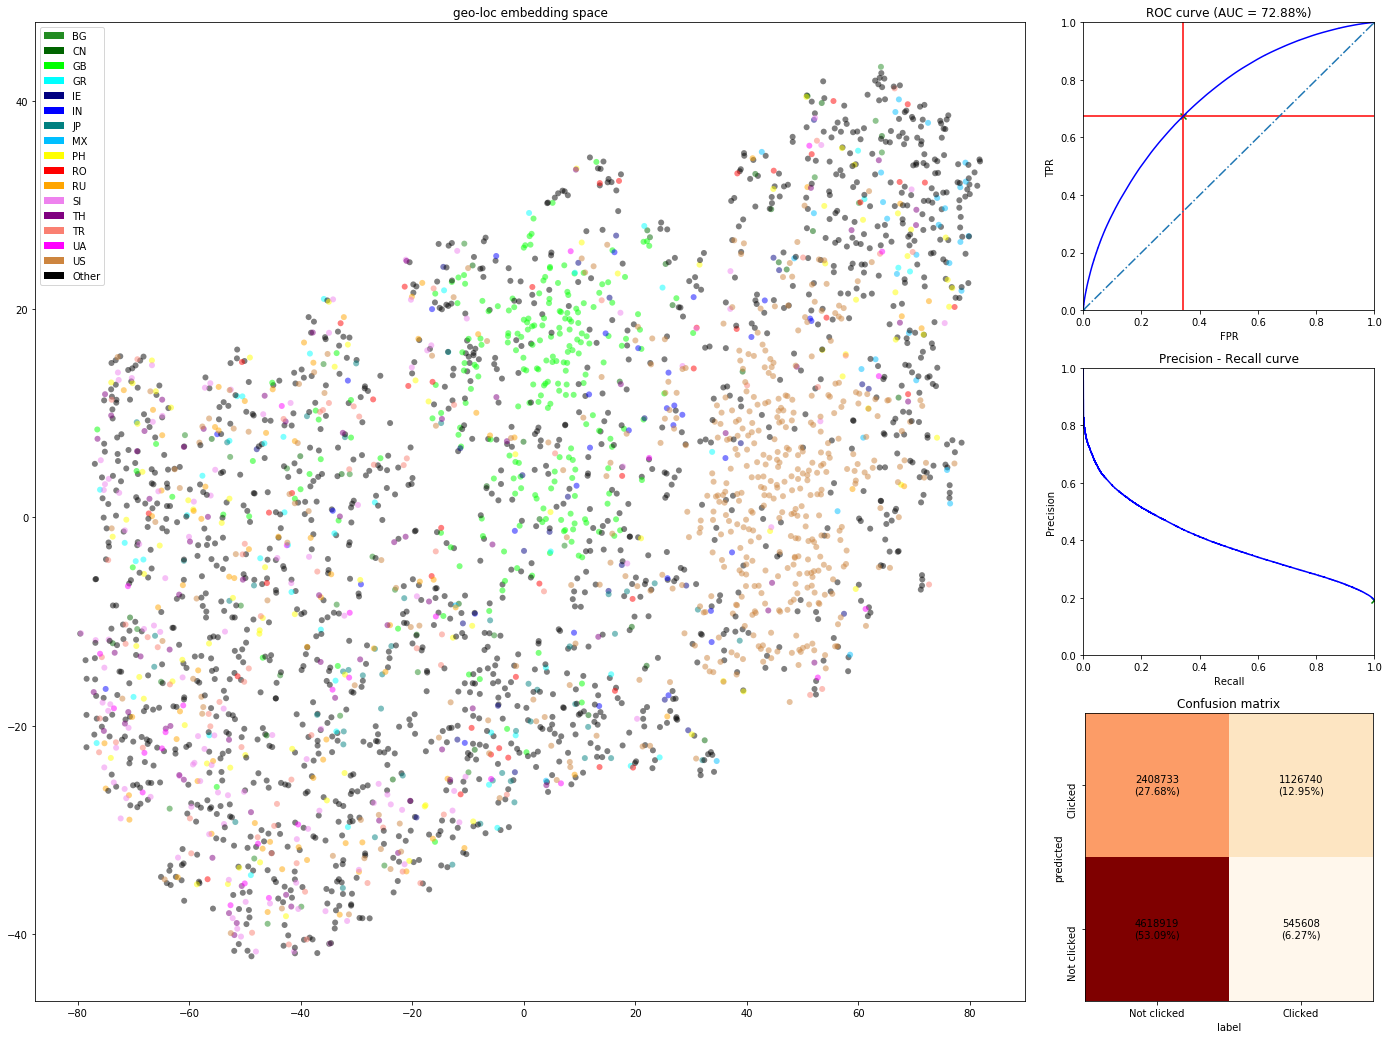

34800/34800 - 1296s - accuracy: 0.6550 - val_loss: 0.6099 - val_auc_1: 0.3972 - val_accuracy: 0.6560 - auc: 0.7314 - val_auc: 0.7269 - auc_1: 0.4026 - loss: 0.2075
34800/34800 - 1296s - accuracy: 0.6590 - val_loss: 0.6099 - val_auc_1: 0.3979 - val_accuracy: 0.6547 - auc: 0.7350 - val_auc: 0.7274 - auc_1: 0.4079 - loss: 0.1904
34800/34800 - 1297s - accuracy: 0.6594 - val_loss: 0.6064 - val_auc_1: 0.4000 - val_accuracy: 0.6594 - auc: 0.7353 - val_auc: 0.7283 - auc_1: 0.4083 - loss: 0.1903
34800/34800 - 1297s - accuracy: 0.6598 - val_loss: 0.6145 - val_auc_1: 0.3984 - val_accuracy: 0.6526 - auc: 0.7354 - val_auc: 0.7269 - auc_1: 0.4085 - loss: 0.1903
34800/34800 - 1296s - accuracy: 0.6597 - val_loss: 0.6029 - val_auc_1: 0.3990 - val_accuracy: 0.6634 - auc: 0.7354 - val_auc: 0.7282 - auc_1: 0.4088 - loss: 0.1903
34800/34800 - 1294s - accuracy: 0.6599 - val_loss: 0.6049 - val_auc_1: 0.3975 - val_accuracy: 0.6616 - auc: 0.7355 - val_auc: 0.7279 - auc_1: 0.4090 - loss: 0.1903
34800/34800 - 12

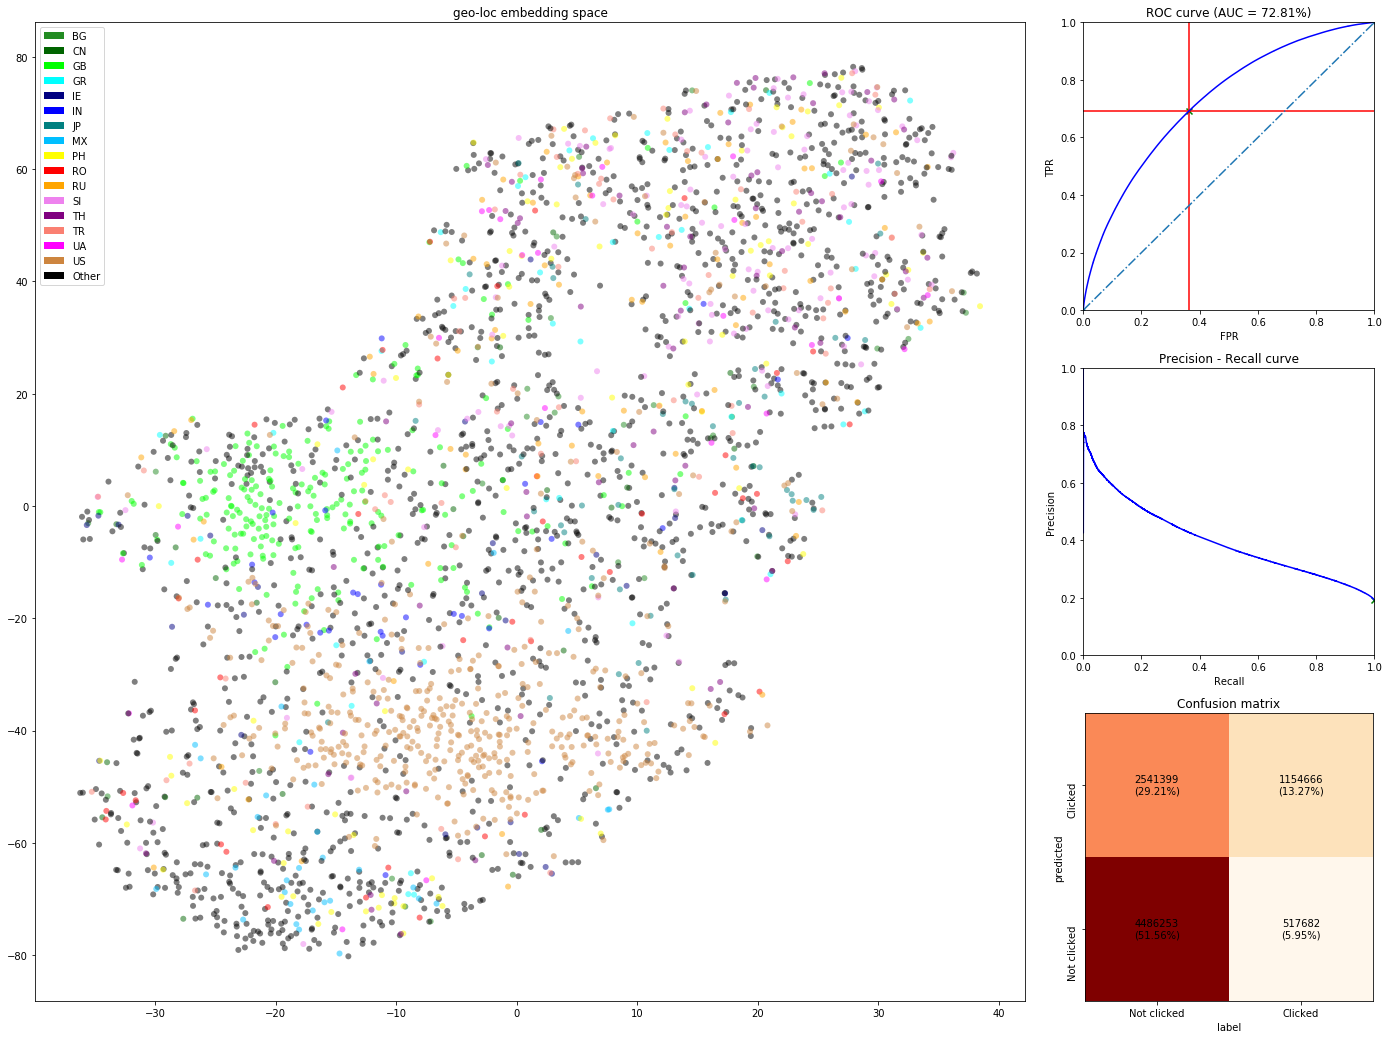

34800/34800 - 1299s - accuracy: 0.6594 - val_loss: 0.6138 - val_auc_1: 0.3994 - val_accuracy: 0.6541 - auc: 0.7324 - val_auc: 0.7283 - auc_1: 0.4035 - loss: 0.2077
34800/34800 - 1302s - accuracy: 0.6618 - val_loss: 0.6144 - val_auc_1: 0.3998 - val_accuracy: 0.6509 - auc: 0.7356 - val_auc: 0.7288 - auc_1: 0.4087 - loss: 0.1903
34800/34800 - 1302s - accuracy: 0.6620 - val_loss: 0.6114 - val_auc_1: 0.4002 - val_accuracy: 0.6567 - auc: 0.7359 - val_auc: 0.7280 - auc_1: 0.4092 - loss: 0.1902
34800/34800 - 1302s - accuracy: 0.6614 - val_loss: 0.6244 - val_auc_1: 0.4000 - val_accuracy: 0.6405 - auc: 0.7361 - val_auc: 0.7284 - auc_1: 0.4096 - loss: 0.1901
34800/34800 - 1302s - accuracy: 0.6612 - val_loss: 0.6146 - val_auc_1: 0.3993 - val_accuracy: 0.6508 - auc: 0.7363 - val_auc: 0.7279 - auc_1: 0.4098 - loss: 0.1901
34800/34800 - 1302s - accuracy: 0.6604 - val_loss: 0.6174 - val_auc_1: 0.4003 - val_accuracy: 0.6461 - auc: 0.7363 - val_auc: 0.7279 - auc_1: 0.4100 - loss: 0.1901
34800/34800 - 13

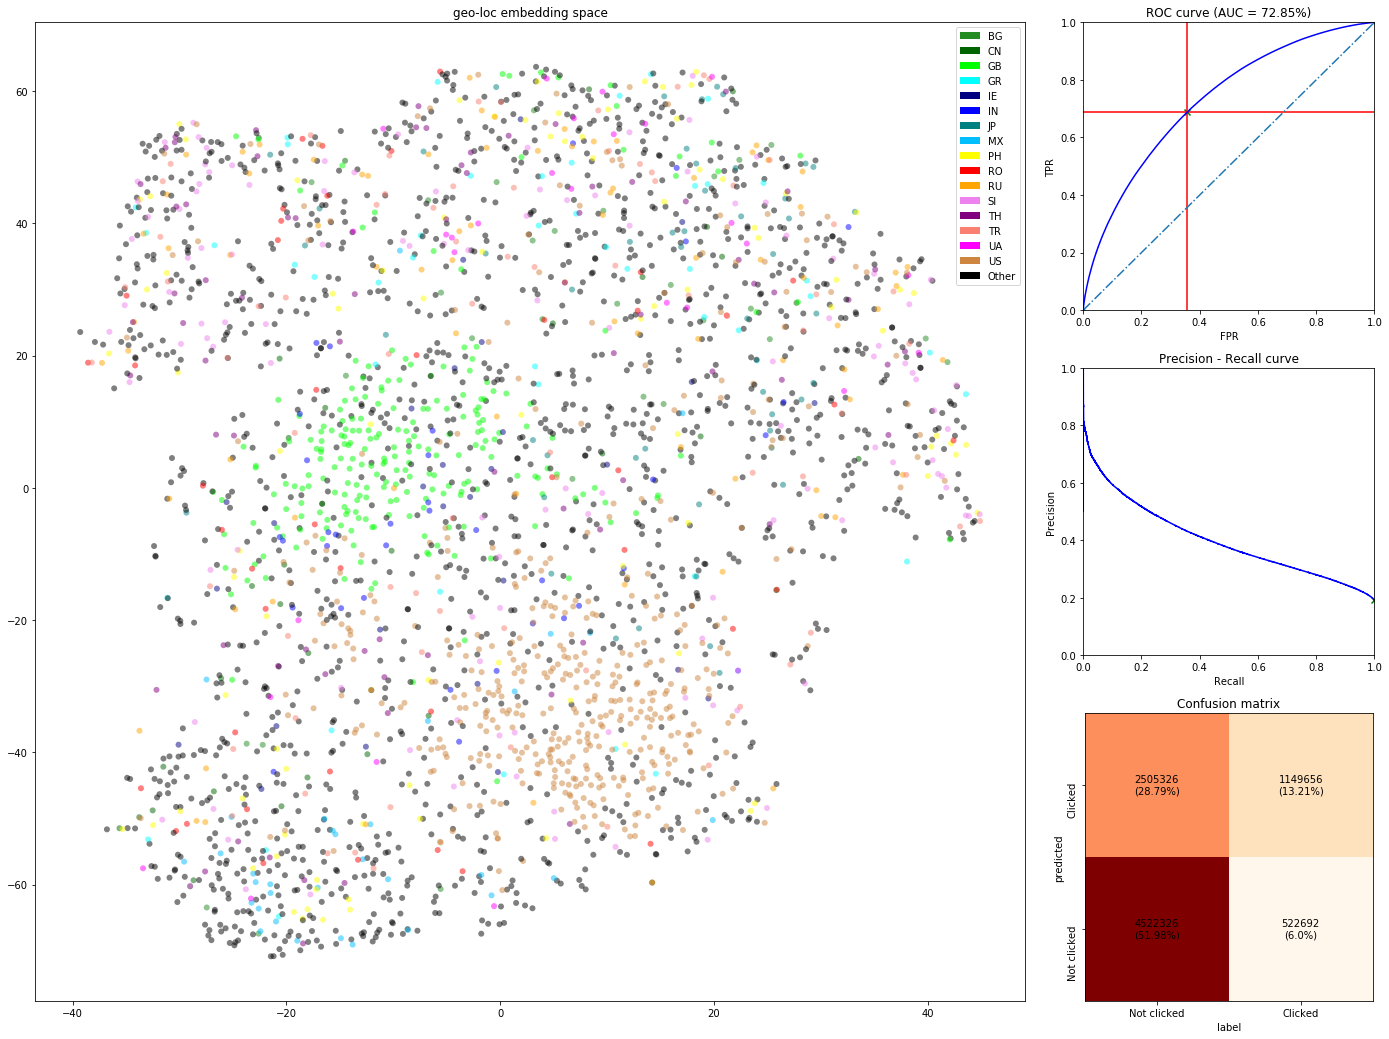

34800/34800 - 1776s - accuracy: 0.6605 - val_loss: 0.6098 - val_auc_1: 0.3972 - val_accuracy: 0.6610 - auc: 0.7319 - val_auc: 0.7267 - auc_1: 0.4031 - loss: 0.2108
34800/34800 - 1772s - accuracy: 0.6637 - val_loss: 0.6140 - val_auc_1: 0.3983 - val_accuracy: 0.6562 - auc: 0.7350 - val_auc: 0.7282 - auc_1: 0.4075 - loss: 0.1904
34800/34800 - 1771s - accuracy: 0.6642 - val_loss: 0.6105 - val_auc_1: 0.3990 - val_accuracy: 0.6575 - auc: 0.7352 - val_auc: 0.7278 - auc_1: 0.4080 - loss: 0.1904
34800/34800 - 1771s - accuracy: 0.6643 - val_loss: 0.6070 - val_auc_1: 0.3990 - val_accuracy: 0.6612 - auc: 0.7354 - val_auc: 0.7276 - auc_1: 0.4082 - loss: 0.1904
34800/34800 - 1769s - accuracy: 0.6644 - val_loss: 0.6094 - val_auc_1: 0.3976 - val_accuracy: 0.6596 - auc: 0.7354 - val_auc: 0.7274 - auc_1: 0.4084 - loss: 0.1903
34800/34800 - 1770s - accuracy: 0.6646 - val_loss: 0.6033 - val_auc_1: 0.3988 - val_accuracy: 0.6682 - auc: 0.7355 - val_auc: 0.7284 - auc_1: 0.4085 - loss: 0.1903
34800/34800 - 17

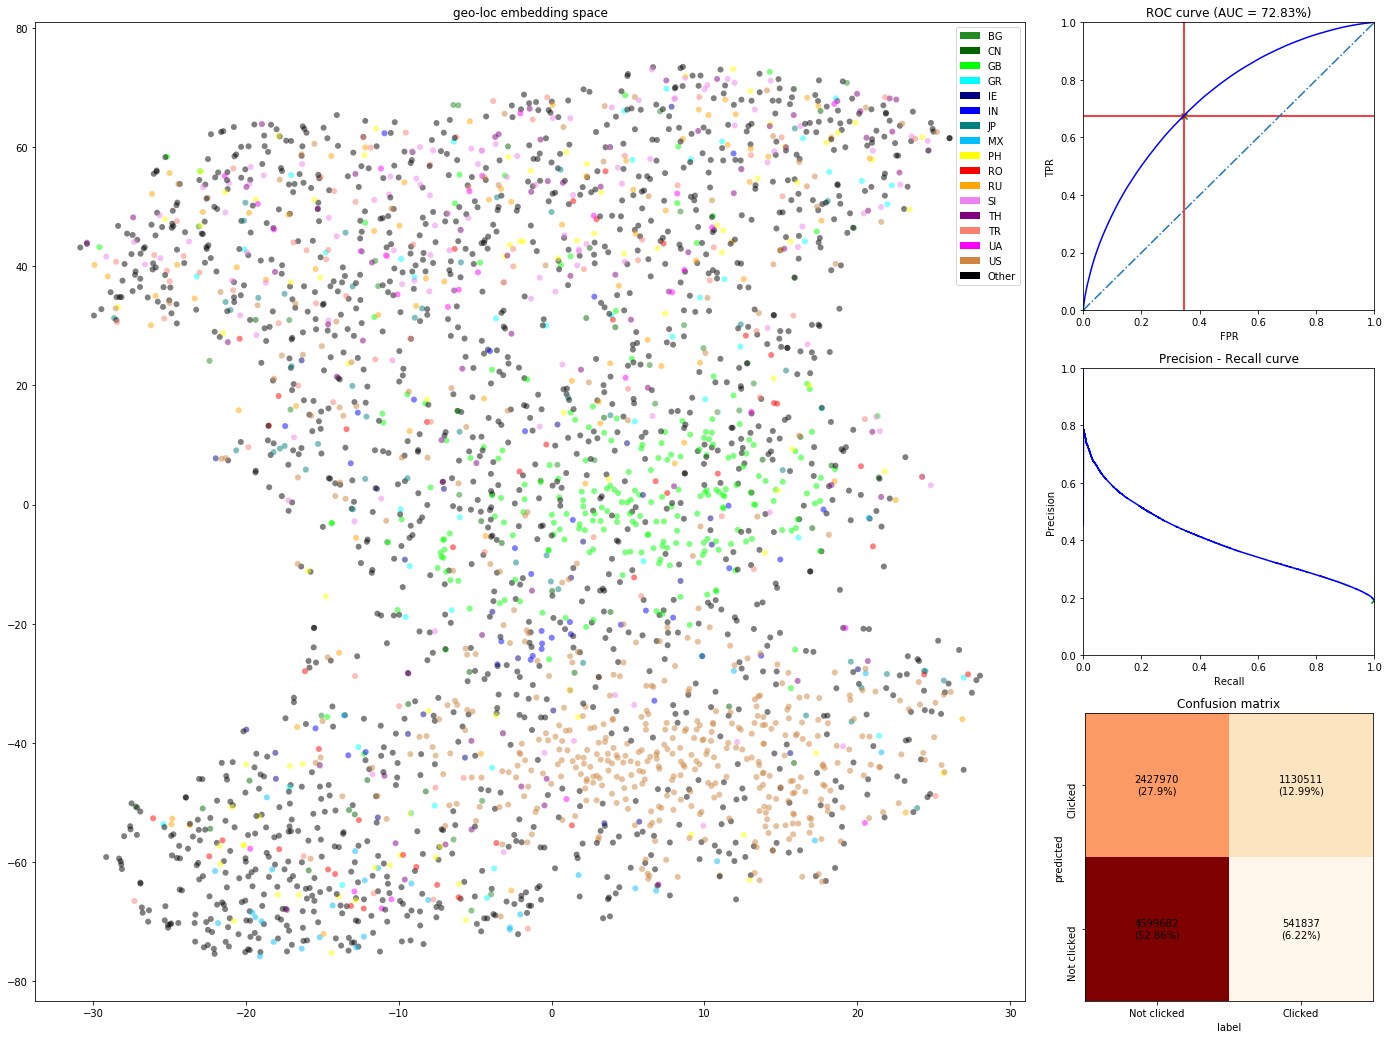

34800/34800 - 1767s - accuracy: 0.6540 - val_loss: 0.6053 - val_auc_1: 0.3980 - val_accuracy: 0.6519 - auc: 0.7323 - val_auc: 0.7275 - auc_1: 0.4033 - loss: 0.2109
34800/34800 - 1769s - accuracy: 0.6559 - val_loss: 0.6033 - val_auc_1: 0.3978 - val_accuracy: 0.6549 - auc: 0.7353 - val_auc: 0.7280 - auc_1: 0.4081 - loss: 0.1903
34800/34800 - 1769s - accuracy: 0.6568 - val_loss: 0.5930 - val_auc_1: 0.3986 - val_accuracy: 0.6675 - auc: 0.7356 - val_auc: 0.7274 - auc_1: 0.4086 - loss: 0.1902
34800/34800 - 1768s - accuracy: 0.6573 - val_loss: 0.5944 - val_auc_1: 0.3988 - val_accuracy: 0.6676 - auc: 0.7358 - val_auc: 0.7276 - auc_1: 0.4088 - loss: 0.1902
34800/34800 - 1768s - accuracy: 0.6580 - val_loss: 0.6002 - val_auc_1: 0.3984 - val_accuracy: 0.6604 - auc: 0.7359 - val_auc: 0.7286 - auc_1: 0.4089 - loss: 0.1901
34800/34800 - 1769s - accuracy: 0.6581 - val_loss: 0.6104 - val_auc_1: 0.3983 - val_accuracy: 0.6525 - auc: 0.7359 - val_auc: 0.7284 - auc_1: 0.4088 - loss: 0.1901
34800/34800 - 17

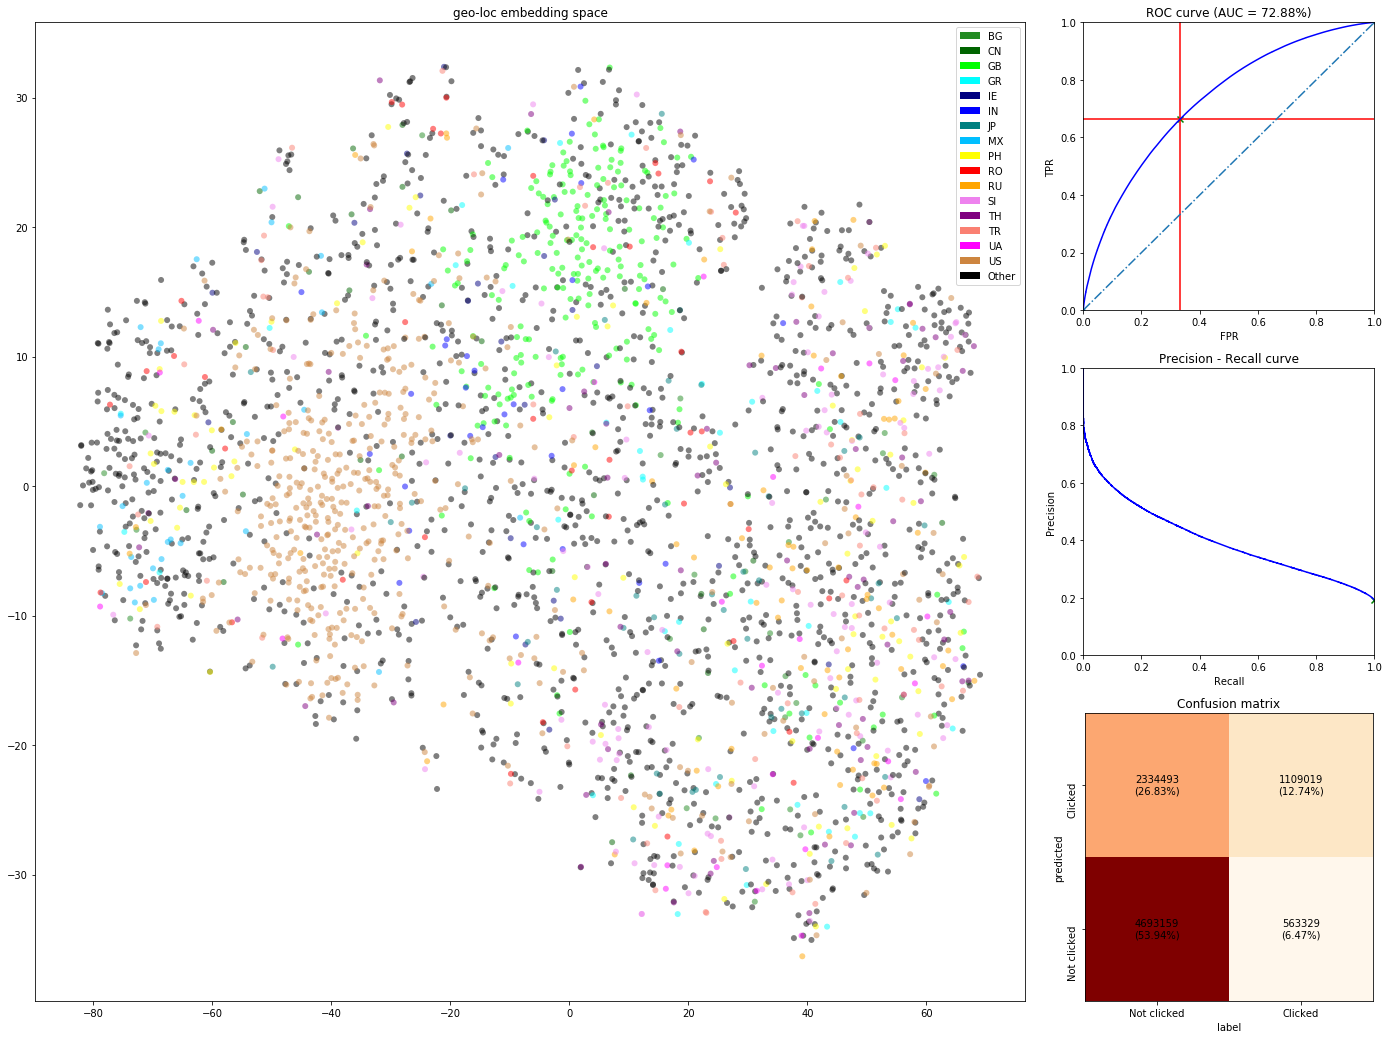

34800/34800 - 2272s - accuracy: 0.6558 - val_loss: 0.6119 - val_auc_1: 0.3964 - val_accuracy: 0.6524 - auc: 0.7318 - val_auc: 0.7263 - auc_1: 0.4030 - loss: 0.2135
34800/34800 - 2271s - accuracy: 0.6589 - val_loss: 0.6103 - val_auc_1: 0.3981 - val_accuracy: 0.6546 - auc: 0.7352 - val_auc: 0.7275 - auc_1: 0.4083 - loss: 0.1905
34800/34800 - 2270s - accuracy: 0.6594 - val_loss: 0.6098 - val_auc_1: 0.3987 - val_accuracy: 0.6533 - auc: 0.7354 - val_auc: 0.7278 - auc_1: 0.4087 - loss: 0.1905
34800/34800 - 2269s - accuracy: 0.6596 - val_loss: 0.6070 - val_auc_1: 0.3990 - val_accuracy: 0.6580 - auc: 0.7355 - val_auc: 0.7281 - auc_1: 0.4090 - loss: 0.1905
34800/34800 - 2269s - accuracy: 0.6596 - val_loss: 0.6108 - val_auc_1: 0.3997 - val_accuracy: 0.6532 - auc: 0.7355 - val_auc: 0.7284 - auc_1: 0.4090 - loss: 0.1904
34800/34800 - 2269s - accuracy: 0.6593 - val_loss: 0.6054 - val_auc_1: 0.3987 - val_accuracy: 0.6578 - auc: 0.7355 - val_auc: 0.7275 - auc_1: 0.4089 - loss: 0.1904
34800/34800 - 22

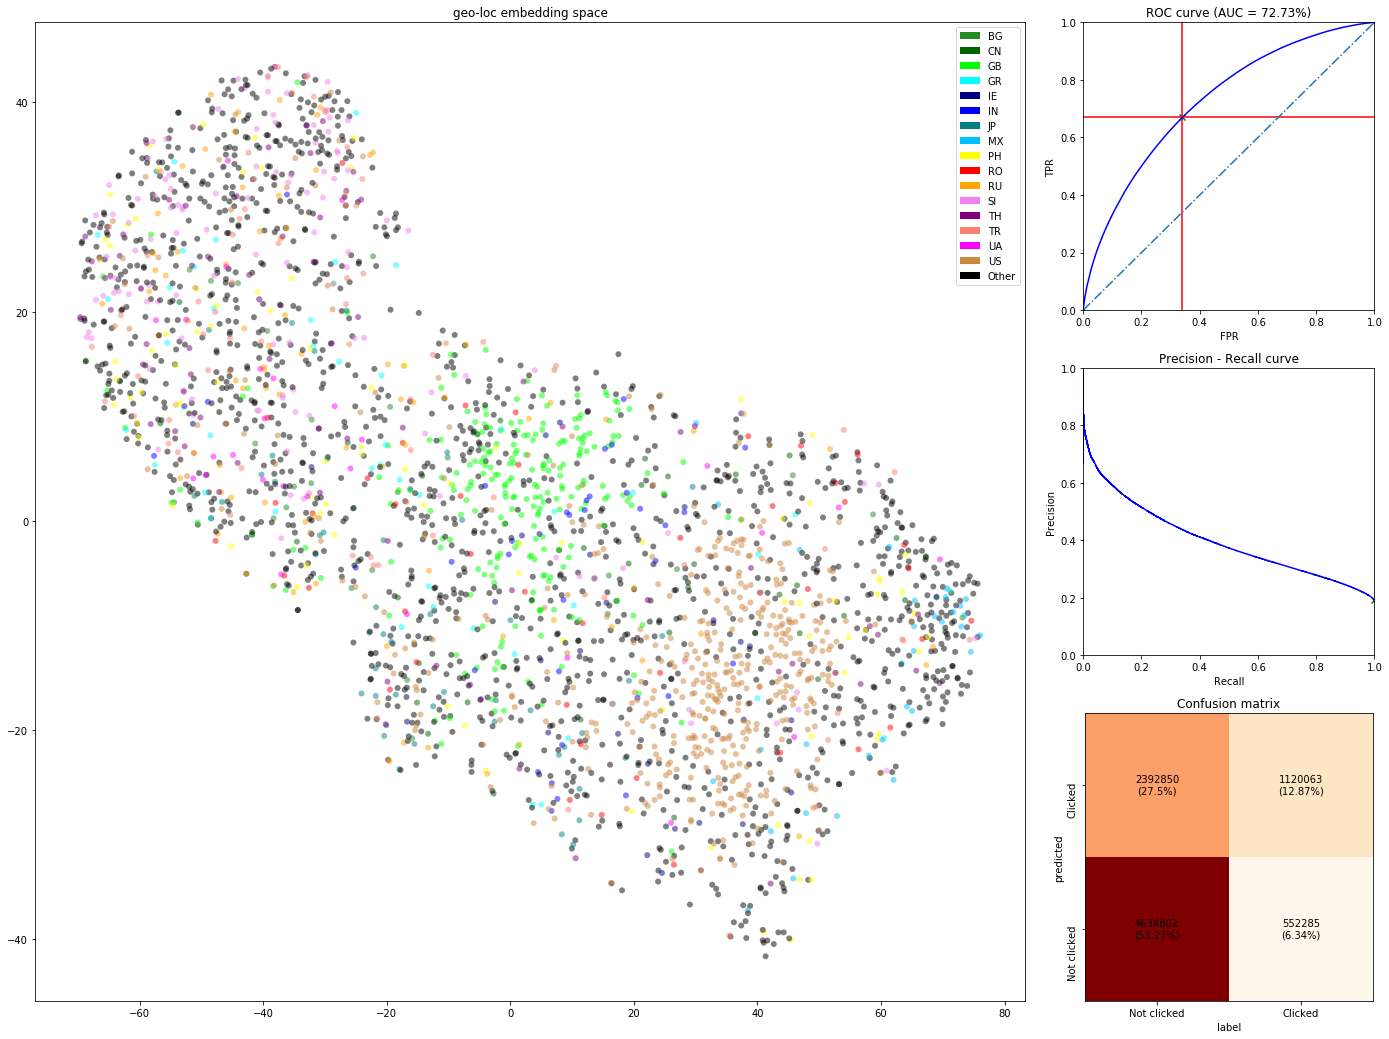

34800/34800 - 2297s - accuracy: 0.6599 - val_loss: 0.6061 - val_auc_1: 0.3985 - val_accuracy: 0.6591 - auc: 0.7327 - val_auc: 0.7276 - auc_1: 0.4044 - loss: 0.2136
34800/34800 - 2298s - accuracy: 0.6620 - val_loss: 0.6118 - val_auc_1: 0.3986 - val_accuracy: 0.6546 - auc: 0.7354 - val_auc: 0.7280 - auc_1: 0.4082 - loss: 0.1904
34800/34800 - 2298s - accuracy: 0.6620 - val_loss: 0.6032 - val_auc_1: 0.3995 - val_accuracy: 0.6610 - auc: 0.7356 - val_auc: 0.7285 - auc_1: 0.4085 - loss: 0.1903
34800/34800 - 2299s - accuracy: 0.6624 - val_loss: 0.6008 - val_auc_1: 0.3997 - val_accuracy: 0.6651 - auc: 0.7357 - val_auc: 0.7284 - auc_1: 0.4087 - loss: 0.1903
34800/34800 - 2299s - accuracy: 0.6628 - val_loss: 0.6048 - val_auc_1: 0.4006 - val_accuracy: 0.6621 - auc: 0.7358 - val_auc: 0.7285 - auc_1: 0.4088 - loss: 0.1903
34800/34800 - 2299s - accuracy: 0.6631 - val_loss: 0.6004 - val_auc_1: 0.3996 - val_accuracy: 0.6651 - auc: 0.7359 - val_auc: 0.7282 - auc_1: 0.4088 - loss: 0.1902
34800/34800 - 22

In [ ]:
interaction_dim = 8
num_inter = 8
triple_interactions = True
head_net_dropout = 0.95
interaction_net_dropout = 0.95
embedding_dropout = 0.95
interaction_net_l2_regularization = 0.5
embedding_l2_regularization = 0.5
head_net_l2_regularization = 0.5
embedding_base_factor = 24
head_layers = 8
head_neck_width = 512
tf.keras.backend.clear_session()
model_layers = {"inputs":[], "embeddeds":[], "intermediated":[], "interacted":[]}
embed_sizes = []
for f in range(num_fields):
    field_name = fields[f]
    field_size = field_sizes[f]
    embedding_size = embedding_size_from_field_size(field_size, dataset.shape[0], emb_base=embedding_base_factor)
    embed_sizes.append(embedding_size)
    this_input = keras.Input(shape=(), name=field_name + "_input")
    model_layers['inputs'].append(this_input)
    this_embedded = layers.Dropout(embedding_dropout)(layers.Embedding(field_size, embedding_size, name="embedding_" + fields[f], activity_regularizer=tf.keras.regularizers.l2(embedding_l2_regularization))(this_input))
    model_layers['embeddeds'].append(this_embedded)
interaction_indices = []
if triple_interactions == True:
    for f1 in range(num_fields - 2):
        for f2 in range(f1 + 1, num_fields - 1):
            for f3 in range(f2 + 1, num_fields):
                inps = [layers.concatenate([model_layers["embeddeds"][f1], model_layers["embeddeds"][f2], model_layers["embeddeds"][f3]], name='cat_' + fields[f1] + "_" + fields[f2] + "_" + fields[f3])]
                intermediate_layers = []
                for l in range(num_inter):
                    intermediate_layers.append(layers.Dense(int(1 + embed_sizes[f1] + embed_sizes[f2] + embed_sizes[f3] + (interaction_dim - 1 - embed_sizes[f1] - embed_sizes[f2] - embed_sizes[f3]) / (num_inter + 1) * (l + 1)), name="intermediate_layer_" + "_" + str(l + 1) + "_" + fields[f1] + "_" + fields[f2] + "_" + fields[f3], activation=layers.LeakyReLU(), kernel_regularizer=tf.keras.regularizers.l2(interaction_net_l2_regularization)))
                    inps.append(layers.Dropout(interaction_net_dropout)(intermediate_layers[-1](inps[-1])))
                model_layers["intermediated"].append(inps[-1])
                interaction_indices.append((f1, f2, f3))
    for i in range(len(model_layers["intermediated"])):
        intermediated = model_layers["intermediated"][i]
        interaction_layer = layers.Dense(interaction_dim, name="interaction_" + fields[interaction_indices[i][0]] + "_" + fields[interaction_indices[i][1]] + "_" + fields[interaction_indices[i][2]], activation=layers.LeakyReLU(), kernel_regularizer=tf.keras.regularizers.l2(interaction_net_l2_regularization))
        interacted = interaction_layer(intermediated)
        model_layers["interacted"].append(interacted)
else:
    for f1 in range(num_fields - 1):
        for f2 in range(f1 + 1, num_fields):
            inps = [layers.concatenate([model_layers["embeddeds"][f1], model_layers["embeddeds"][f2]], name='cat_' + fields[f1] + "_" + fields[f2])]
            intermediate_layers = []
            for l in range(num_inter):
                intermediate_layers.append(layers.Dense(int(1 + embed_sizes[f1] + embed_sizes[f2] + (interaction_dim - 1 - embed_sizes[f1] - embed_sizes[f2]) / (num_inter + 1) * (l + 1)), name="intermediate_layer_" + "_" + str(l + 1) + "_" + fields[f1] + "_" + fields[f2], activation=layers.LeakyReLU(), kernel_regularizer=tf.keras.regularizers.l2(interaction_net_l2_regularization)))
                inps.append(layers.Dropout(interaction_net_dropout)(intermediate_layers[-1](inps[-1])))
            model_layers["intermediated"].append(inps[-1])
            interaction_indices.append((f1, f2))
    for i in range(len(model_layers["intermediated"])):
        intermediated = model_layers["intermediated"][i]
        interaction_layer = layers.Dense(interaction_dim, name="interaction_" + fields[interaction_indices[i][0]] + "_" + fields[interaction_indices[i][1]], activation=layers.LeakyReLU(), kernel_regularizer=tf.keras.regularizers.l2(interaction_net_l2_regularization))
        interacted = interaction_layer(intermediated)
        model_layers["interacted"].append(interacted)
catlist = model_layers["embeddeds"] + model_layers["interacted"]
cat = layers.concatenate(catlist, name='cat')
head_layers_list = []
head_tensors_list = [cat]
for i in range(head_layers):
    head_layers_list.append(layers.Dense(head_neck_width, activation=layers.LeakyReLU(), name="head_layer_" + str(i), kernel_regularizer=tf.keras.regularizers.l2(head_net_l2_regularization)))
    head_tensors_list.append(layers.Dropout(head_net_dropout)(head_layers_list[-1](head_tensors_list[-1])))
y = layers.Dense(1, activation='sigmoid', name='y')(head_tensors_list[-1])
model = keras.Model(
    inputs=model_layers["inputs"],
    outputs=[y],
)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(curve="ROC"), tf.keras.metrics.AUC(curve="PR")])
for ep in range(100):
    gc.collect()
    hist = model.fit(x=[dataset[:validation_start, j] for j in list(range(0, label_col)) + list(range(label_col + 1, num_fields + 1))],
                     y=dataset[:validation_start, label_col],
                     epochs=1,
                     batch_size=10000,
                     class_weight={0:ones_percentage, 1:zeros_percentage},
                     validation_data=([dataset[validation_start:test_start, j] for j in list(range(0, label_col)) + list(range(label_col + 1, num_fields + 1))], [dataset[validation_start:test_start, label_col]]),
                     shuffle=True,
                     verbose=2,)
    y_pred = model.predict(x=[dataset[:, j] for j in range(1, 13)], batch_size=100000)
if triple_interactions:
    triple_name = "_TripleInteractions"
else:
    triple_name = ""
draw_function(save_location="Results_Proposed__"
              + "_EmbeddingL2Reg" + str(embedding_l2_regularization)
              + "_EmbeddingDropout" + str(embedding_dropout)
              + "_IntermediateLayers" + str(num_inter)
              + "_InteractionL2Reg" + str(interaction_net_l2_regularization)
              + "_InteractionNetDropout" + str(interaction_net_dropout)
              + "_FeaturesInteractionDim" + str(interaction_dim)
              + "_HeadLayers" + str(head_layers)
              + "_HeadNeckWidth" + str(head_neck_width)
              + "_HeadNetL2Reg" + str(head_net_l2_regularization)
              + "_HeadNetDropout" + str(head_net_dropout)
              + "_EmbeddingBaseFactor" + str(embedding_base_factor)
              + triple_name + ".png")